# Importing Libraries

In [25]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import os
from imutils import paths
import glob

# Loading dataset

In [26]:
print("[INFO] loading images...")
class_name = []
label_dict ={}
def getClassData(path):
    i = 0
    class_dict = {}
    class_name = []
    for filename in glob.iglob(path+"**/*",recursive=True):
        file = filename.split('\\')[-1]
        label = file.split('.')[0]
        file = np.load(filename)
        class_dict[i] = label
        if (i == 0):
            file = np.c_[file, np.zeros(len(file))]
        else : 
            file = np.c_[file, i*np.ones(len(file))]
        class_name.append(file)
        i += 1
    return class_name, class_dict
path='Dataset'
class_name, label_dict = getClassData(path)

[INFO] loading images...


In [28]:
class_name = np.array(class_name)
y = []
for i in range(len(class_name)):
    y.extend(class_name[i][:15000,-1])
y=np.array(y)
print(y)

In [34]:
for i in range(len(class_name)):
    class_name[i] = class_name[i][:15000, :-1]
    print(class_name[i].shape)
class_data = []
print(class_name[0].shape)
for i in range(len(class_name)):
    class_data.extend(class_name[i])
class_data = np.array(class_data)
X = class_data

(15000, 784)
(15000, 784)
(15000, 784)
(15000, 784)
(15000, 784)
(15000, 784)
(15000, 784)
(15000, 784)
(15000, 784)
(15000, 784)


# Train-Test Split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X/255.,y,test_size=0.4,random_state=0)

In [42]:
y_train_cnn = np_utils.to_categorical(y_train)
y_test_cnn = np_utils.to_categorical(y_test)
num_classes = y_test_cnn.shape[1]

In [43]:
X_train_cnn = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

# Creating, Training and Evaluation CNN Model

In [44]:
def cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    print("[INFO] compiling model...")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [45]:
# build the model
print("[INFO] creating model...")
model = cnn_model()
# Fit the model
print("[INFO] training model...")
records = model.fit(X_train_cnn, y_train_cnn, validation_split=0.3, epochs=10, batch_size=200)
# Final evaluation of the model
print("[INFO] evaluating model...")
scores = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Final CNN accuracy: ', scores[1])

[INFO] creating model...
[INFO] compiling model...
[INFO] training model...
Train on 62999 samples, validate on 27001 samples
Epoch 1/10
62999/62999 [==============================] - 82s 1ms/step - loss: 0.6973 - acc: 0.7868 - val_loss: 0.4009 - val_acc: 0.8830
Epoch 2/10
62999/62999 [==============================] - 60s 956us/step - loss: 0.3630 - acc: 0.8921 - val_loss: 0.3023 - val_acc: 0.9119
Epoch 3/10
62999/62999 [==============================] - 54s 862us/step - loss: 0.3000 - acc: 0.9090 - val_loss: 0.2657 - val_acc: 0.9211
Epoch 4/10
62999/62999 [==============================] - 53s 841us/step - loss: 0.2633 - acc: 0.9209 - val_loss: 0.2450 - val_acc: 0.9280
Epoch 5/10
62999/62999 [==============================] - 54s 855us/step - loss: 0.2419 - acc: 0.9257 - val_loss: 0.2302 - val_acc: 0.9329
Epoch 6/10
62999/62999 [==============================] - 56s 896us/step - loss: 0.2249 - acc: 0.9315 - val_loss: 0.2179 - val_acc: 0.936257 - acc: 0
Epoch 7/10
62999/62999 [=======

# Saving Model

In [ ]:
print("[INFO] saving model...")
model.save("model.h5")

# Curves and Graphs

C:\Users\Devashi Jain\DMG\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


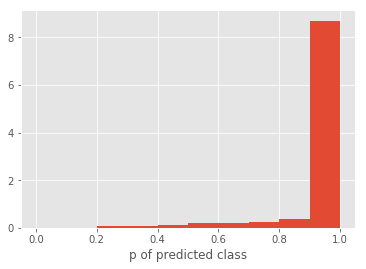

In [48]:
import matplotlib.pyplot as plt
cnn_probab = model.predict(X_test_cnn, batch_size=32, verbose=0)

# extract the probability for the label that was predicted:
p_max = np.amax(cnn_probab, axis=1)

plt.hist(p_max, normed=True, bins=list(np.linspace(0,1,11)));
plt.xlabel('p of predicted class');

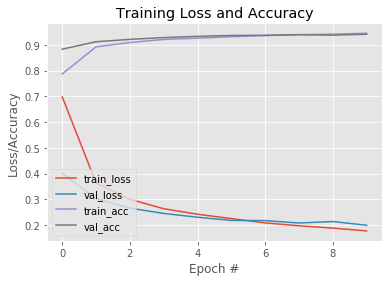

In [47]:
N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), records.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), records.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), records.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), records.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")